In [1]:
import pandas as pd
import sqlite3

In [2]:
df= pd.read_excel(r"C:\Users\abdulmuiz.adewale\OneDrive - Tolaram Pte Ltd\Project Done\Data\Online Retail.xlsx")
df.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#creating a pipeline
conn= sqlite3.connect(":memory:")

#Naming the DB
database= df.to_sql("retail_virt", conn, index=False, if_exists="replace")

In [4]:
query = """
SELECT *
FROM retail_virt
WHERE Quantity OR UnitPrice IS NULL
"""
result= pd.read_sql_query(query, conn)
result.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


## Data Cleaning

In [5]:
query = """
    With unnull_retail_virt as
        (
        SELECT *
        FROM retail_virt
        WHERE CustomerID IS NOT NULL)
        
    , quantity_filtered as  
        (
        SELECT *
        FROM unnull_retail_virt 
        WHERE Quantity > 0 AND UnitPrice > 0)
        
    , duplicate_flag as
        (
        SELECT *, ROW_NUMBER() OVER(partition by InvoiceNo, StockCode, Quantity ORDER BY InvoiceDate)dup_flag
        FROM quantity_filtered )

        --- SELECT * 
        --- FROM duplicate_flag 
        --- WHERE InvoiceNo = "536412" AND StockCode = "21448" AND dup_flag IN (1,2,3)

        SELECT *
        FROM duplicate_flag
        
"""
result= pd.read_sql_query(query, conn)
result.to_sql("online_retail", conn, index=False, if_exists= "replace")

397884

In [6]:
query = """
            SELECT *
            FROM online_retail
"""
result= pd.read_sql_query(query, conn)
result.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,dup_flag
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,1
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,1
2,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1


In [7]:
# first time a goods was purchsed by a cust
query = """
        SELECT CustomerID, min(InvoiceDate) AS first_invoice_date, 
        strftime("%Y-%m-01", min(InvoiceDate)) AS cohort_date
        FROM online_retail
        GROUP BY CustomerID
"""
result= pd.read_sql_query(query, conn)
result.to_sql("cohort", conn, index=False, if_exists="replace")
#result.head(5)

4338

In [8]:
# Cohort Index
query = """
        SELECT mmm.*, 
                (year_diff *12 + month_diff +1) as cohort_index

        FROM (
        
        SELECT mm.*,
                (invoice_year - cohort_year) AS year_diff,
                (invoice_month - cohort_month) AS month_diff
        FROM(
        
        SELECT m.*, 
                c.cohort_date,
                strftime("%Y", m.InvoiceDate) as invoice_year,
                strftime("%m", m.InvoiceDate) as invoice_month,
                strftime("%Y", c.cohort_date) as cohort_year,
                strftime("%m", c.cohort_date) as cohort_month
        FROM onLine_retail as m
        LEFT JOIN cohort as c
         ON m.CustomerID = c.CustomerID
         )mm

         )mmm

"""
result= pd.read_sql_query(query, conn)
result.to_sql("cohort_index", conn, index=False, if_exists="replace")

397884

In [9]:
query = """
            SELECT *
            FROM cohort_index
"""
result= pd.read_sql_query(query, conn)
result.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,dup_flag,cohort_date,invoice_year,invoice_month,cohort_year,cohort_month,year_diff,month_diff,cohort_index
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,1,2010-12-01,2010,12,2010,12,0,0,1
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,1,2010-12-01,2010,12,2010,12,0,0,1


In [15]:
query = """
            SELECT DISTINCT(CustomerID), cohort_date, cohort_index
            FROM cohort_index
            WHERE cohort_index >12
"""
result= pd.read_sql_query(query, conn)
result.head(5)

,CustomerID,cohort_date,cohort_index
0,14911.0,2010-12-01,13
1,16839.0,2010-12-01,13
2,13854.0,2010-12-01,13
3,14146.0,2010-12-01,13
4,15101.0,2010-12-01,13


In [18]:
query = """
            SELECT *
            FROM cohort_index
"""
result= pd.read_sql_query(query, conn)
result.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,dup_flag,cohort_date,invoice_year,invoice_month,cohort_year,cohort_month,year_diff,month_diff,cohort_index
0,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom,1,2010-12-01,2010,12,2010,12,0,0,1
1,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom,1,2010-12-01,2010,12,2010,12,0,0,1


In [26]:
#cohort_retention analysis
query = """
            SELECT cohort_date,
                    COUNT(DISTINCT CASE WHEN cohort_index= 1 THEN CustomerID END) AS "1st_purchase",
                    COUNT(DISTINCT CASE WHEN cohort_index= 2 THEN CustomerID END) AS ">_1",
                    COUNT(DISTINCT CASE WHEN cohort_index= 3 THEN CustomerID END) AS ">_2",
                    COUNT(DISTINCT CASE WHEN cohort_index= 4 THEN CustomerID END) AS ">_3",
                    COUNT(DISTINCT CASE WHEN cohort_index= 5 THEN CustomerID END) AS ">_4",
                    COUNT(DISTINCT CASE WHEN cohort_index= 6 THEN CustomerID END) AS ">_5",
                    COUNT(DISTINCT CASE WHEN cohort_index= 7 THEN CustomerID END) AS ">_6",
                    COUNT(DISTINCT CASE WHEN cohort_index= 8 THEN CustomerID END) AS ">_7",
                    COUNT(DISTINCT CASE WHEN cohort_index= 9 THEN CustomerID END) AS ">_8",
                    COUNT(DISTINCT CASE WHEN cohort_index= 10 THEN CustomerID END) AS ">_9",
                    COUNT(DISTINCT CASE WHEN cohort_index= 11 THEN CustomerID END) AS ">_10",
                    COUNT(DISTINCT CASE WHEN cohort_index= 12 THEN CustomerID END) AS ">_11",
                    COUNT(DISTINCT CASE WHEN cohort_index= 13 THEN CustomerID END) AS ">_12"
                FROM cohort_index
                GROUP BY cohort_date
                ORDER BY cohort_date
"""
result= pd.read_sql_query(query, conn)
result.to_sql("cohort_pivot", conn, index=False, if_exists="replace")

13

In [37]:
query = """
            SELECT *
            FROM cohort_pivot
"""
result= pd.read_sql_query(query, conn)
result

,cohort_date,1st_purchase,>_1,>_2,>_3,>_4,>_5,>_6,>_7,>_8,>_9,>_10,>_11,>_12
0,2010-12-01,885,324,286,340,321,352,321,309,313,350,331,445,235
1,2011-01-01,417,92,111,96,134,120,103,101,125,136,152,49,0
2,2011-02-01,380,71,71,108,103,94,96,106,94,116,26,0,0
3,2011-03-01,452,68,114,90,101,76,121,104,126,39,0,0,0
4,2011-04-01,300,64,61,63,59,68,65,78,22,0,0,0,0
5,2011-05-01,284,54,49,49,59,66,75,27,0,0,0,0,0
6,2011-06-01,242,42,38,64,56,81,23,0,0,0,0,0,0
7,2011-07-01,188,34,39,42,51,21,0,0,0,0,0,0,0
8,2011-08-01,169,35,42,41,21,0,0,0,0,0,0,0,0
9,2011-09-01,299,70,90,34,0,0,0,0,0,0,0,0,0


In [44]:
#cohort percentage
#cohort_retention analysis
query = """
            SELECT cohort_date,
                     Round(100.0 * "1st_purchase"/"1st_purchase", 0) AS "1st_purchase",
                     Round(100.0 * ">_1"/"1st_purchase", 0) AS ">_1",
                     Round(100.0 * ">_2"/"1st_purchase", 0) AS ">_2",
                     Round(100.0 * ">_3"/"1st_purchase", 0) AS ">_3",
                     Round(100.0 * ">_4"/"1st_purchase", 0) AS ">_4",
                     Round(100.0 * ">_5"/"1st_purchase", 0) AS ">_5",
                     Round(100.0 * ">_6"/"1st_purchase", 0) AS ">_6",
                     Round(100.0 * ">_7"/"1st_purchase", 0) AS ">_7",
                     Round(100.0 * ">_8"/"1st_purchase", 0) AS ">_8",
                     Round(100.0 * ">_9"/"1st_purchase", 0) AS ">_9",
                     Round(100.0 * ">_10"/"1st_purchase", 0) AS ">_10",
                     Round(100.0 * ">_11"/"1st_purchase", 0) AS ">_11",
                     Round(100.0 * ">_12"/"1st_purchase", 0) AS ">_12"
                FROM cohort_pivot
                GROUP BY cohort_date
                ORDER BY cohort_date
"""
result= pd.read_sql_query(query, conn)
result.to_sql("cohort_percent", conn, index=False, if_exists="replace")

13

In [46]:
query = """
            SELECT *
            FROM cohort_percent
"""
result= pd.read_sql_query(query, conn)
result

,cohort_date,1st_purchase,>_1,>_2,>_3,>_4,>_5,>_6,>_7,>_8,>_9,>_10,>_11,>_12
0,2010-12-01,100.0,37.0,32.0,38.0,36.0,40.0,36.0,35.0,35.0,40.0,37.0,50.0,27.0
1,2011-01-01,100.0,22.0,27.0,23.0,32.0,29.0,25.0,24.0,30.0,33.0,36.0,12.0,0.0
2,2011-02-01,100.0,19.0,19.0,28.0,27.0,25.0,25.0,28.0,25.0,31.0,7.0,0.0,0.0
3,2011-03-01,100.0,15.0,25.0,20.0,22.0,17.0,27.0,23.0,28.0,9.0,0.0,0.0,0.0
4,2011-04-01,100.0,21.0,20.0,21.0,20.0,23.0,22.0,26.0,7.0,0.0,0.0,0.0,0.0
5,2011-05-01,100.0,19.0,17.0,17.0,21.0,23.0,26.0,10.0,0.0,0.0,0.0,0.0,0.0
6,2011-06-01,100.0,17.0,16.0,26.0,23.0,33.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2011-07-01,100.0,18.0,21.0,22.0,27.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2011-08-01,100.0,21.0,25.0,24.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2011-09-01,100.0,23.0,30.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

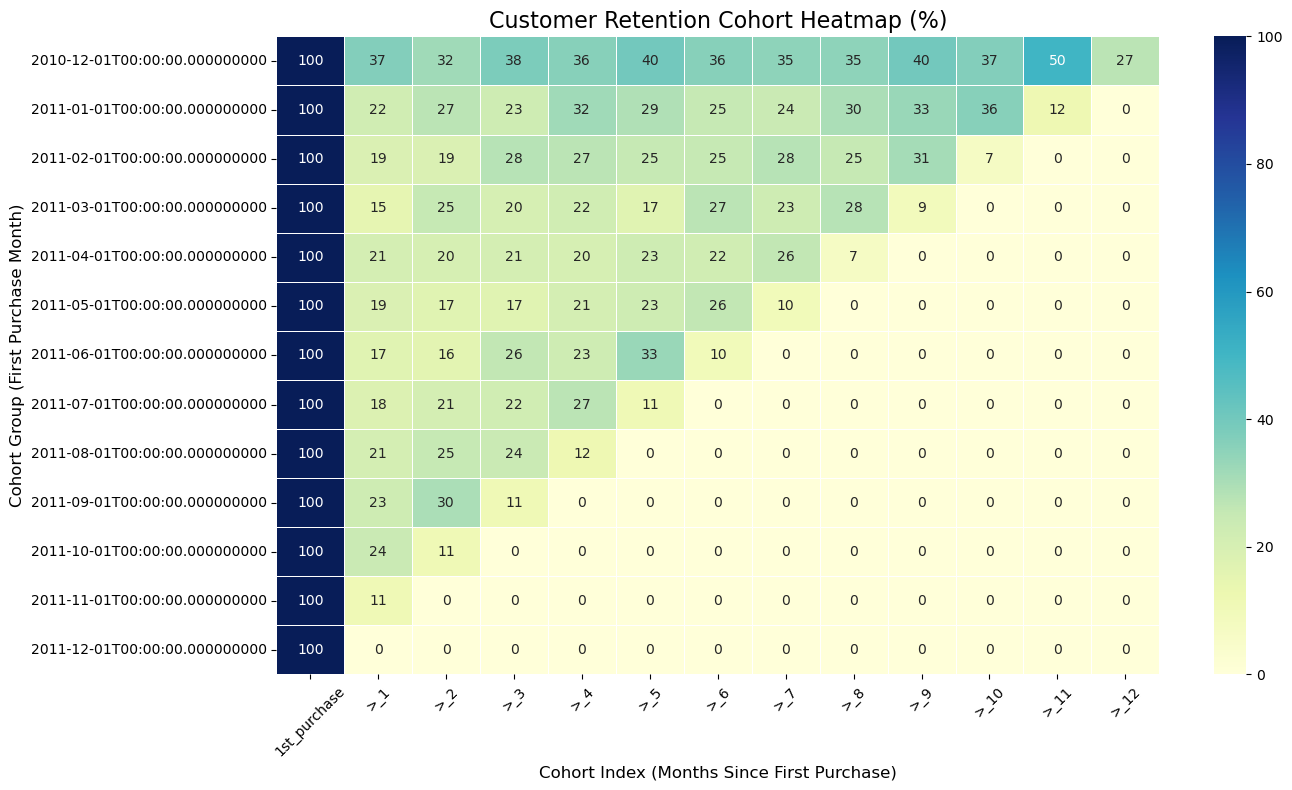

In [48]:
#selecting the cohort percentage
query = """
            SELECT *
            FROM cohort_percent
"""
result= pd.read_sql_query(query, conn)

#converting cohort_date to datetime format
result["cohort_date"]= pd.to_datetime(result["cohort_date"])

#set cohort_date as index
result.set_index("cohort_date", inplace=True)

#sort index
result.sort_index(inplace=True)

#Heatmap creation
plt.figure(figsize=(14, 8))
sns.heatmap(result, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=0.5)

plt.title("Customer Retention Cohort Heatmap (%)", fontsize=16)
plt.xlabel("Cohort Index (Months Since First Purchase)", fontsize=12)
plt.ylabel("Cohort Group (First Purchase Month)", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()